<a href="https://colab.research.google.com/github/sikbo/Git_tutorial/blob/main/yolo_nas(correction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

print(torch.version.cuda)

11.8


In [ ]:
!pip list

In [2]:
!pip install -q super-gradients==3.2.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 1.1.3 requires pyparsing==2.4.7, but you have pyparsing 2.4.5 which is incompatible.


In [3]:
!pip install roboflow

  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.5
    Uninstalling pyparsing-2.4.5:
      Successfully uninstalled pyparsing-2.4.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
super-gradients 3.2.0 requires pyparsing==2.4.5, but you have pyparsing 2.4.7 which is incompatible.


In [4]:
!pip install supervision

In [27]:
import torch
from super_gradients.training import models

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_ARCH = 'yolo_nas_l'
#            'yolo_nas_m'
#            'yolo_nas_s'

model1 = models.get(MODEL_ARCH, pretrained_weights="coco").to(DEVICE)

[2023-08-23 14:45:57] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-08-23 14:45:59] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


[2023-08-23 14:46:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


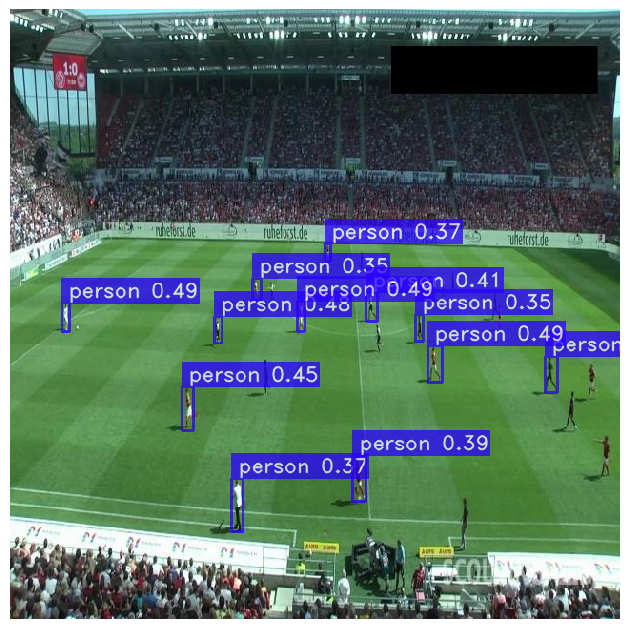

In [29]:
image = '/content/Football-Players-Detection-1/test/images/40cd38_7_6_png_jpg.rf.c2137d868f1fce50ac3132526ff22abc.jpg'
CONFIDENCE_TRESHOLD = 0.35

result = list(model1.predict(image, conf=CONFIDENCE_TRESHOLD))[0].show()


In [6]:
import roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="EBwZmSUIkPfvLJEjyekH")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-2frwp")
dataset = project.version(1).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Football-Players-Detection-1 in yolov5pytorch::  49%|████▉     | 1116/2258 [00:00<00:00, 2807.72it/s]

In [7]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

Extracting Dataset Version Zip to Football-Players-Detection-1 in yolov5pytorch:: 100%|██████████| 2258/2258 [00:00<00:00, 3812.41it/s]


In [8]:
MODEL_ARCH = 'yolo_nas_l'
BATCH_SIZE = 5
MAX_EPOCHS = 15
EXPERIMENT_NAME = project.name.lower().replace(" ", "_")
LOCATION = dataset.location
CLASSES = ['ball', 'goalkeeper', 'player', 'referee']
WORKERS = 2

dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'/content/Football-Players-Detection-1/train/images',
    'train_labels_dir':'/content/Football-Players-Detection-1/train/labels',
    'val_images_dir':'/content/Football-Players-Detection-1/valid/images',
    'val_labels_dir':'/content/Football-Players-Detection-1/valid/labels',
    'test_images_dir':'/content/Football-Players-Detection-1/test/images',
    'test_labels_dir':'/content/Football-Players-Detection-1/test/labels',
    'classes': CLASSES
}

from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': WORKERS
    }
)

[2023-08-23 13:34:43] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1072/1072 [00:00<00:00, 3722.50it/s]
[2023-08-23 13:34:43] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


In [ ]:
train_data.dataset.transforms

In [ ]:
train_data.dataset.transforms.pop(2)

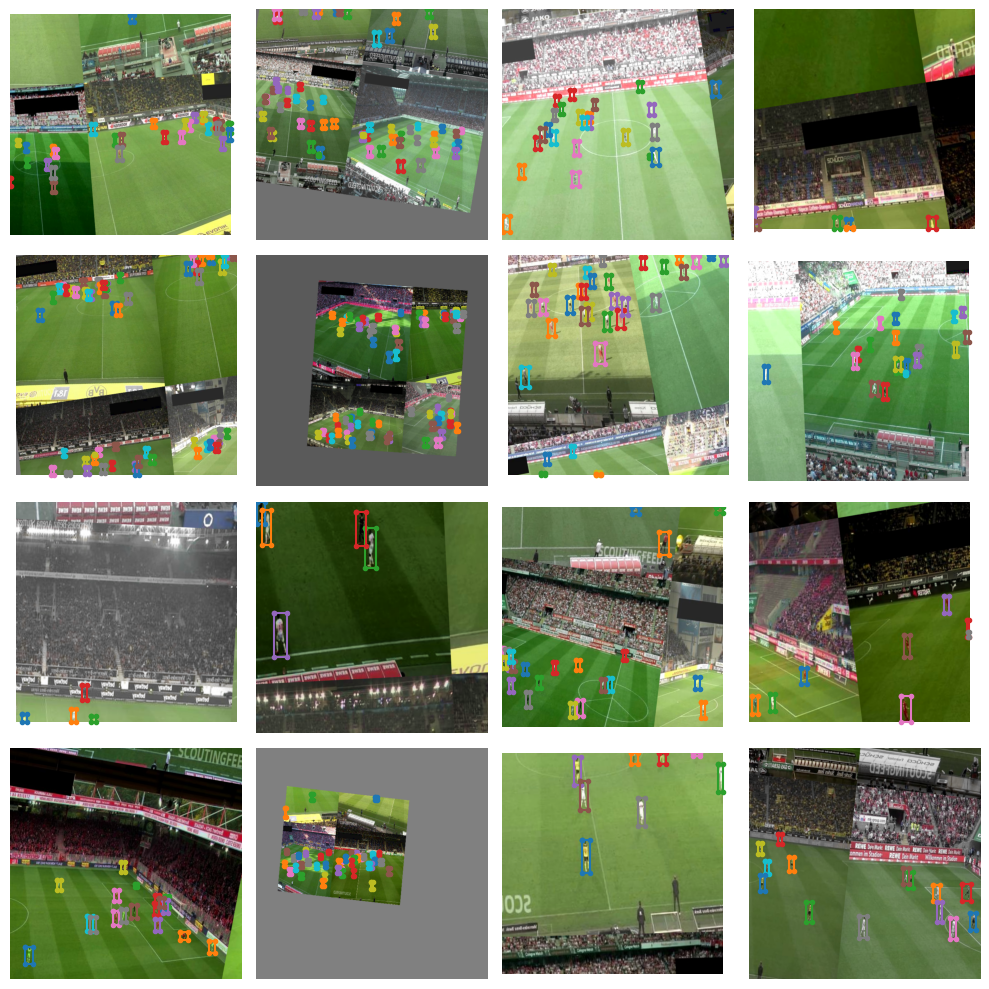

In [17]:
train_data.dataset.plot(plot_transformed_data=True)

In [9]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [10]:
models_to_train = [
    'yolo_nas_s',
    #'yolo_nas_m',
    #'yolo_nas_l'
]

CHECKPOINT_DIR = 'checkpoints'

model_to_train = 'yolo_nas_s'  # 원하는 모델 선택

trainer = Trainer(
    experiment_name=model_to_train,
    ckpt_root_dir=CHECKPOINT_DIR
)

model = models.get(
    model_to_train,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)


[2023-08-23 13:34:52] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-08-23 13:34:53] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


The console stream is now moved to checkpoints/yolo_nas_s/console_Aug23_13_34_53.txt


[2023-08-23 13:34:54] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-08-23 13:34:56] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 1072       (len(train_set))
    - Batch size per GPU:           5          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             5          (num_gpus * batch_size)
    - Effective Batch size:         5          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         214        (len(train_loader))
    - Gradient updates per epoch:   214        (len(train_loader) / batch_accumulate)

[2023-08-23 13:34:56] INFO - sg_trainer.py - Started training for 15 epochs (0/14)

Validating: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
[2023-08-23 13:37:02] INFO - base_sg_logger.py - 

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.2272
│   ├── Ppyoloeloss/loss_iou = 0.3849
│   ├── Ppyoloeloss/loss_dfl = 0.9674
│   └── Ppyoloeloss/loss = 3.6733
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.1022
    ├── Ppyoloeloss/loss_iou = 0.2804
    ├── Ppyoloeloss/loss_dfl = 0.6888
    ├── Ppyoloeloss/loss = 3.1477
    ├── Precision@0.50 = 0.1894
    ├── Recall@0.50 = 0.0239
    ├── Map@0.50 = 0.0596
    ├── F1@0.50 = 0.0424
    ├── Precision@0.50:0.95 = 0.0955
    ├── Recall@0.50:0.95 = 0.0119
    ├── Map@0.50:0.95 = 0.0222
    └── F1@0.50:0.95 = 0.0211



Validating epoch 1: 100%|██████████| 8/8 [00:03<00:00,  2.45it/s]
[2023-08-23 13:39:03] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-23 13:39:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.10541771352291107


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9082
│   │   ├── Epoch N-1      = 2.2272 (↘ -1.319)
│   │   └── Best until now = 2.2272 (↘ -1.319)
│   ├── Ppyoloeloss/loss_iou = 0.2693
│   │   ├── Epoch N-1      = 0.3849 (↘ -0.1157)
│   │   └── Best until now = 0.3849 (↘ -0.1157)
│   ├── Ppyoloeloss/loss_dfl = 0.6924
│   │   ├── Epoch N-1      = 0.9674 (↘ -0.275)
│   │   └── Best until now = 0.9674 (↘ -0.275)
│   └── Ppyoloeloss/loss = 1.9276
│       ├── Epoch N-1      = 3.6733 (↘ -1.7456)
│       └── Best until now = 3.6733 (↘ -1.7456)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8502
    │   ├── Epoch N-1      = 2.1022 (↘ -1.252)
    │   └── Best until now = 2.1022 (↘ -1.252)
    ├── Ppyoloeloss/loss_iou = 0.2475
    │   ├── Epoch N-1      = 0.2804 (↘ -0.033)
    │   └── Best until now = 0.2804 (↘ -0.033)
    ├── Ppyoloeloss/loss_dfl = 0.6289
    │   ├── Epoch N-1      = 0.6888 (↘ -0.0599)
    │   └── Best until now = 0.6888 (↘ -0.0599)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 2: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
[2023-08-23 13:41:05] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-23 13:41:05] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.237807959318161


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8352
│   │   ├── Epoch N-1      = 0.9082 (↘ -0.073)
│   │   └── Best until now = 0.9082 (↘ -0.073)
│   ├── Ppyoloeloss/loss_iou = 0.2438
│   │   ├── Epoch N-1      = 0.2693 (↘ -0.0255)
│   │   └── Best until now = 0.2693 (↘ -0.0255)
│   ├── Ppyoloeloss/loss_dfl = 0.6595
│   │   ├── Epoch N-1      = 0.6924 (↘ -0.0329)
│   │   └── Best until now = 0.6924 (↘ -0.0329)
│   └── Ppyoloeloss/loss = 1.7744
│       ├── Epoch N-1      = 1.9276 (↘ -0.1532)
│       └── Best until now = 1.9276 (↘ -0.1532)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8051
    │   ├── Epoch N-1      = 0.8502 (↘ -0.0451)
    │   └── Best until now = 0.8502 (↘ -0.0451)
    ├── Ppyoloeloss/loss_iou = 0.2108
    │   ├── Epoch N-1      = 0.2475 (↘ -0.0367)
    │   └── Best until now = 0.2475 (↘ -0.0367)
    ├── Ppyoloeloss/loss_dfl = 0.6076
    │   ├── Epoch N-1      = 0.6289 (↘ -0.0214)
    │   └── Best until now = 0.6289 (↘ -0.0214)
    ├── Ppyoloeloss/loss

Validating epoch 3: 100%|██████████| 8/8 [00:03<00:00,  2.50it/s]
[2023-08-23 13:43:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-23 13:43:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.28053951263427734


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8093
│   │   ├── Epoch N-1      = 0.8352 (↘ -0.0259)
│   │   └── Best until now = 0.8352 (↘ -0.0259)
│   ├── Ppyoloeloss/loss_iou = 0.2413
│   │   ├── Epoch N-1      = 0.2438 (↘ -0.0025)
│   │   └── Best until now = 0.2438 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.6508
│   │   ├── Epoch N-1      = 0.6595 (↘ -0.0087)
│   │   └── Best until now = 0.6595 (↘ -0.0087)
│   └── Ppyoloeloss/loss = 1.738
│       ├── Epoch N-1      = 1.7744 (↘ -0.0365)
│       └── Best until now = 1.7744 (↘ -0.0365)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7816
    │   ├── Epoch N-1      = 0.8051 (↘ -0.0235)
    │   └── Best until now = 0.8051 (↘ -0.0235)
    ├── Ppyoloeloss/loss_iou = 0.2207
    │   ├── Epoch N-1      = 0.2108 (↗ 0.01)
    │   └── Best until now = 0.2108 (↗ 0.01)
    ├── Ppyoloeloss/loss_dfl = 0.6038
    │   ├── Epoch N-1      = 0.6076 (↘ -0.0037)
    │   └── Best until now = 0.6076 (↘ -0.0037)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 4: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]
[2023-08-23 13:45:16] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-23 13:45:16] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3202107548713684


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7847
│   │   ├── Epoch N-1      = 0.8093 (↘ -0.0246)
│   │   └── Best until now = 0.8093 (↘ -0.0246)
│   ├── Ppyoloeloss/loss_iou = 0.2337
│   │   ├── Epoch N-1      = 0.2413 (↘ -0.0076)
│   │   └── Best until now = 0.2413 (↘ -0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.6384
│   │   ├── Epoch N-1      = 0.6508 (↘ -0.0124)
│   │   └── Best until now = 0.6508 (↘ -0.0124)
│   └── Ppyoloeloss/loss = 1.6881
│       ├── Epoch N-1      = 1.738  (↘ -0.0498)
│       └── Best until now = 1.738  (↘ -0.0498)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7422
    │   ├── Epoch N-1      = 0.7816 (↘ -0.0394)
    │   └── Best until now = 0.7816 (↘ -0.0394)
    ├── Ppyoloeloss/loss_iou = 0.2086
    │   ├── Epoch N-1      = 0.2207 (↘ -0.0121)
    │   └── Best until now = 0.2108 (↘ -0.0021)
    ├── Ppyoloeloss/loss_dfl = 0.5922
    │   ├── Epoch N-1      = 0.6038 (↘ -0.0116)
    │   └── Best until now = 0.6038 (↘ -0.0116)
    ├── Ppyoloeloss/lo

Validating epoch 5: 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7627
│   │   ├── Epoch N-1      = 0.7847 (↘ -0.022)
│   │   └── Best until now = 0.7847 (↘ -0.022)
│   ├── Ppyoloeloss/loss_iou = 0.2256
│   │   ├── Epoch N-1      = 0.2337 (↘ -0.0081)
│   │   └── Best until now = 0.2337 (↘ -0.0081)
│   ├── Ppyoloeloss/loss_dfl = 0.6301
│   │   ├── Epoch N-1      = 0.6384 (↘ -0.0083)
│   │   └── Best until now = 0.6384 (↘ -0.0083)
│   └── Ppyoloeloss/loss = 1.6418
│       ├── Epoch N-1      = 1.6881 (↘ -0.0463)
│       └── Best until now = 1.6881 (↘ -0.0463)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7595
    │   ├── Epoch N-1      = 0.7422 (↗ 0.0173)
    │   └── Best until now = 0.7422 (↗ 0.0173)
    ├── Ppyoloeloss/loss_iou = 0.209
    │   ├── Epoch N-1      = 0.2086 (↗ 0.0003)
    │   └── Best until now = 0.2086 (↗ 0.0003)
    ├── Ppyoloeloss/loss_dfl = 0.5902
    │   ├── Epoch N-1      = 0.5922 (↘ -0.002)
    │   └── Best until now = 0.5922 (↘ -0.002)
    ├── Ppyoloeloss/loss = 1.57

Validating epoch 6: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]
[2023-08-23 13:49:27] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-23 13:49:27] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3479970097541809


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7508
│   │   ├── Epoch N-1      = 0.7627 (↘ -0.0119)
│   │   └── Best until now = 0.7627 (↘ -0.0119)
│   ├── Ppyoloeloss/loss_iou = 0.219
│   │   ├── Epoch N-1      = 0.2256 (↘ -0.0066)
│   │   └── Best until now = 0.2256 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.6254
│   │   ├── Epoch N-1      = 0.6301 (↘ -0.0047)
│   │   └── Best until now = 0.6301 (↘ -0.0047)
│   └── Ppyoloeloss/loss = 1.6111
│       ├── Epoch N-1      = 1.6418 (↘ -0.0307)
│       └── Best until now = 1.6418 (↘ -0.0307)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7146
    │   ├── Epoch N-1      = 0.7595 (↘ -0.0448)
    │   └── Best until now = 0.7422 (↘ -0.0275)
    ├── Ppyoloeloss/loss_iou = 0.1925
    │   ├── Epoch N-1      = 0.209  (↘ -0.0165)
    │   └── Best until now = 0.2086 (↘ -0.0161)
    ├── Ppyoloeloss/loss_dfl = 0.5844
    │   ├── Epoch N-1      = 0.5902 (↘ -0.0058)
    │   └── Best until now = 0.5902 (↘ -0.0058)
    ├── Ppyoloeloss/los

Validating epoch 7: 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]
[2023-08-23 13:51:35] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-23 13:51:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3849303424358368


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7409
│   │   ├── Epoch N-1      = 0.7508 (↘ -0.0099)
│   │   └── Best until now = 0.7508 (↘ -0.0099)
│   ├── Ppyoloeloss/loss_iou = 0.2162
│   │   ├── Epoch N-1      = 0.219  (↘ -0.0028)
│   │   └── Best until now = 0.219  (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.6212
│   │   ├── Epoch N-1      = 0.6254 (↘ -0.0042)
│   │   └── Best until now = 0.6254 (↘ -0.0042)
│   └── Ppyoloeloss/loss = 1.592
│       ├── Epoch N-1      = 1.6111 (↘ -0.0191)
│       └── Best until now = 1.6111 (↘ -0.0191)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7038
    │   ├── Epoch N-1      = 0.7146 (↘ -0.0108)
    │   └── Best until now = 0.7146 (↘ -0.0108)
    ├── Ppyoloeloss/loss_iou = 0.1801
    │   ├── Epoch N-1      = 0.1925 (↘ -0.0124)
    │   └── Best until now = 0.1925 (↘ -0.0124)
    ├── Ppyoloeloss/loss_dfl = 0.5765
    │   ├── Epoch N-1      = 0.5844 (↘ -0.0078)
    │   └── Best until now = 0.5844 (↘ -0.0078)
    ├── Ppyoloeloss/los

Validating epoch 8: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7318
│   │   ├── Epoch N-1      = 0.7409 (↘ -0.0091)
│   │   └── Best until now = 0.7409 (↘ -0.0091)
│   ├── Ppyoloeloss/loss_iou = 0.2116
│   │   ├── Epoch N-1      = 0.2162 (↘ -0.0046)
│   │   └── Best until now = 0.2162 (↘ -0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.6165
│   │   ├── Epoch N-1      = 0.6212 (↘ -0.0046)
│   │   └── Best until now = 0.6212 (↘ -0.0046)
│   └── Ppyoloeloss/loss = 1.5691
│       ├── Epoch N-1      = 1.592  (↘ -0.0229)
│       └── Best until now = 1.592  (↘ -0.0229)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7173
    │   ├── Epoch N-1      = 0.7038 (↗ 0.0135)
    │   └── Best until now = 0.7038 (↗ 0.0135)
    ├── Ppyoloeloss/loss_iou = 0.2034
    │   ├── Epoch N-1      = 0.1801 (↗ 0.0233)
    │   └── Best until now = 0.1801 (↗ 0.0233)
    ├── Ppyoloeloss/loss_dfl = 0.5862
    │   ├── Epoch N-1      = 0.5765 (↗ 0.0097)
    │   └── Best until now = 0.5765 (↗ 0.0097)
    ├── Ppyoloeloss/loss = 1

Validating epoch 9: 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7204
│   │   ├── Epoch N-1      = 0.7318 (↘ -0.0114)
│   │   └── Best until now = 0.7318 (↘ -0.0114)
│   ├── Ppyoloeloss/loss_iou = 0.2086
│   │   ├── Epoch N-1      = 0.2116 (↘ -0.003)
│   │   └── Best until now = 0.2116 (↘ -0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.6106
│   │   ├── Epoch N-1      = 0.6165 (↘ -0.006)
│   │   └── Best until now = 0.6165 (↘ -0.006)
│   └── Ppyoloeloss/loss = 1.5472
│       ├── Epoch N-1      = 1.5691 (↘ -0.0219)
│       └── Best until now = 1.5691 (↘ -0.0219)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7064
    │   ├── Epoch N-1      = 0.7173 (↘ -0.0109)
    │   └── Best until now = 0.7038 (↗ 0.0026)
    ├── Ppyoloeloss/loss_iou = 0.1979
    │   ├── Epoch N-1      = 0.2034 (↘ -0.0055)
    │   └── Best until now = 0.1801 (↗ 0.0178)
    ├── Ppyoloeloss/loss_dfl = 0.5815
    │   ├── Epoch N-1      = 0.5862 (↘ -0.0048)
    │   └── Best until now = 0.5765 (↗ 0.0049)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 10: 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7093
│   │   ├── Epoch N-1      = 0.7204 (↘ -0.0112)
│   │   └── Best until now = 0.7204 (↘ -0.0112)
│   ├── Ppyoloeloss/loss_iou = 0.2043
│   │   ├── Epoch N-1      = 0.2086 (↘ -0.0043)
│   │   └── Best until now = 0.2086 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.609
│   │   ├── Epoch N-1      = 0.6106 (↘ -0.0016)
│   │   └── Best until now = 0.6106 (↘ -0.0016)
│   └── Ppyoloeloss/loss = 1.5245
│       ├── Epoch N-1      = 1.5472 (↘ -0.0227)
│       └── Best until now = 1.5472 (↘ -0.0227)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.705
    │   ├── Epoch N-1      = 0.7064 (↘ -0.0013)
    │   └── Best until now = 0.7038 (↗ 0.0013)
    ├── Ppyoloeloss/loss_iou = 0.1945
    │   ├── Epoch N-1      = 0.1979 (↘ -0.0034)
    │   └── Best until now = 0.1801 (↗ 0.0144)
    ├── Ppyoloeloss/loss_dfl = 0.5771
    │   ├── Epoch N-1      = 0.5815 (↘ -0.0043)
    │   └── Best until now = 0.5765 (↗ 0.0006)
    ├── Ppyoloeloss/loss =

Validating epoch 11: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s]
[2023-08-23 14:00:02] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-23 14:00:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3891676962375641


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7018
│   │   ├── Epoch N-1      = 0.7093 (↘ -0.0075)
│   │   └── Best until now = 0.7093 (↘ -0.0075)
│   ├── Ppyoloeloss/loss_iou = 0.2013
│   │   ├── Epoch N-1      = 0.2043 (↘ -0.003)
│   │   └── Best until now = 0.2043 (↘ -0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.6036
│   │   ├── Epoch N-1      = 0.609  (↘ -0.0054)
│   │   └── Best until now = 0.609  (↘ -0.0054)
│   └── Ppyoloeloss/loss = 1.5067
│       ├── Epoch N-1      = 1.5245 (↘ -0.0178)
│       └── Best until now = 1.5245 (↘ -0.0178)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6775
    │   ├── Epoch N-1      = 0.705  (↘ -0.0275)
    │   └── Best until now = 0.7038 (↘ -0.0262)
    ├── Ppyoloeloss/loss_iou = 0.1775
    │   ├── Epoch N-1      = 0.1945 (↘ -0.017)
    │   └── Best until now = 0.1801 (↘ -0.0026)
    ├── Ppyoloeloss/loss_dfl = 0.5754
    │   ├── Epoch N-1      = 0.5771 (↘ -0.0017)
    │   └── Best until now = 0.5765 (↘ -0.0011)
    ├── Ppyoloeloss/loss

Validating epoch 12: 100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6928
│   │   ├── Epoch N-1      = 0.7018 (↘ -0.0089)
│   │   └── Best until now = 0.7018 (↘ -0.0089)
│   ├── Ppyoloeloss/loss_iou = 0.199
│   │   ├── Epoch N-1      = 0.2013 (↘ -0.0023)
│   │   └── Best until now = 0.2013 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.602
│   │   ├── Epoch N-1      = 0.6036 (↘ -0.0017)
│   │   └── Best until now = 0.6036 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 1.4912
│       ├── Epoch N-1      = 1.5067 (↘ -0.0155)
│       └── Best until now = 1.5067 (↘ -0.0155)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.689
    │   ├── Epoch N-1      = 0.6775 (↗ 0.0114)
    │   └── Best until now = 0.6775 (↗ 0.0114)
    ├── Ppyoloeloss/loss_iou = 0.1861
    │   ├── Epoch N-1      = 0.1775 (↗ 0.0086)
    │   └── Best until now = 0.1775 (↗ 0.0086)
    ├── Ppyoloeloss/loss_dfl = 0.5766
    │   ├── Epoch N-1      = 0.5754 (↗ 0.0011)
    │   └── Best until now = 0.5754 (↗ 0.0011)
    ├── Ppyoloeloss/loss = 1.4

Validating epoch 13: 100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6889
│   │   ├── Epoch N-1      = 0.6928 (↘ -0.0039)
│   │   └── Best until now = 0.6928 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_iou = 0.1966
│   │   ├── Epoch N-1      = 0.199  (↘ -0.0024)
│   │   └── Best until now = 0.199  (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.6001
│   │   ├── Epoch N-1      = 0.602  (↘ -0.0018)
│   │   └── Best until now = 0.602  (↘ -0.0018)
│   └── Ppyoloeloss/loss = 1.4804
│       ├── Epoch N-1      = 1.4912 (↘ -0.0108)
│       └── Best until now = 1.4912 (↘ -0.0108)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6809
    │   ├── Epoch N-1      = 0.689  (↘ -0.0081)
    │   └── Best until now = 0.6775 (↗ 0.0034)
    ├── Ppyoloeloss/loss_iou = 0.1887
    │   ├── Epoch N-1      = 0.1861 (↗ 0.0026)
    │   └── Best until now = 0.1775 (↗ 0.0112)
    ├── Ppyoloeloss/loss_dfl = 0.5771
    │   ├── Epoch N-1      = 0.5766 (↗ 0.0005)
    │   └── Best until now = 0.5754 (↗ 0.0016)
    ├── Ppyoloeloss/loss =

Validating epoch 14: 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6826
│   │   ├── Epoch N-1      = 0.6889 (↘ -0.0064)
│   │   └── Best until now = 0.6889 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.1943
│   │   ├── Epoch N-1      = 0.1966 (↘ -0.0022)
│   │   └── Best until now = 0.1966 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.5965
│   │   ├── Epoch N-1      = 0.6001 (↘ -0.0036)
│   │   └── Best until now = 0.6001 (↘ -0.0036)
│   └── Ppyoloeloss/loss = 1.4666
│       ├── Epoch N-1      = 1.4804 (↘ -0.0138)
│       └── Best until now = 1.4804 (↘ -0.0138)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6837
    │   ├── Epoch N-1      = 0.6809 (↗ 0.0028)
    │   └── Best until now = 0.6775 (↗ 0.0061)
    ├── Ppyoloeloss/loss_iou = 0.1953
    │   ├── Epoch N-1      = 0.1887 (↗ 0.0066)
    │   └── Best until now = 0.1775 (↗ 0.0178)
    ├── Ppyoloeloss/loss_dfl = 0.5749
    │   ├── Epoch N-1      = 0.5771 (↘ -0.0022)
    │   └── Best until now = 0.5754 (↘ -0.0006)
    ├── Ppyoloeloss/loss 

[2023-08-23 14:06:07] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 15: 100%|██████████| 8/8 [00:02<00:00,  4.04it/s]

In [11]:
test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': WORKERS
    }
)

In [14]:
trainer.test(
    model=model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )
)

Testing: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

{'PPYoloELoss/loss_cls': 0.68378705,
 'PPYoloELoss/loss_iou': 0.1951537,
 'PPYoloELoss/loss_dfl': 0.5792748,
 'PPYoloELoss/loss': 1.4613086,
 'Precision@0.50': 0.1559021770954132,
 'Recall@0.50': 0.773368239402771,
 'mAP@0.50': 0.7322327494621277,
 'F1@0.50': 0.24338334798812866}

[2023-08-23 14:46:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


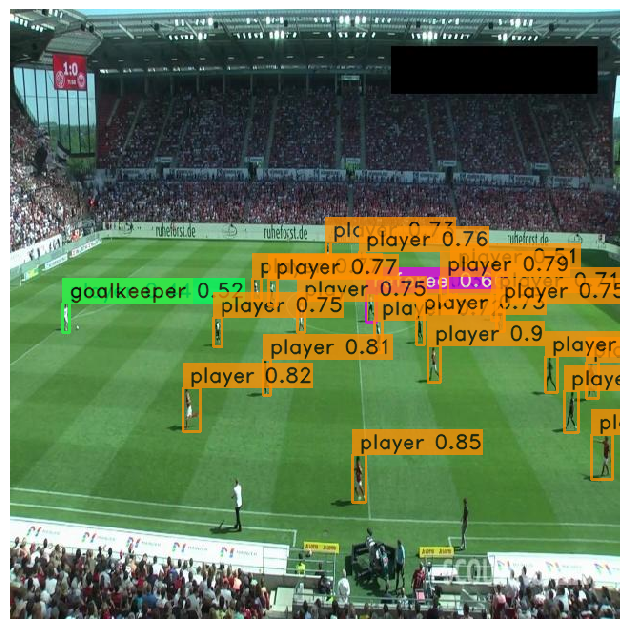

In [30]:
image = '/content/Football-Players-Detection-1/test/images/40cd38_7_6_png_jpg.rf.c2137d868f1fce50ac3132526ff22abc.jpg'
CONFIDENCE_TRESHOLD = 0.35

result = list(model.predict(image, conf=CONFIDENCE_TRESHOLD))[0].show()
